In [6]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = os.path.normpath('D:/Utec/DL/semantic_drone_dataset/Train/')
TEST_PATH = os.path.normpath('D:/Utec/DL/semantic_drone_dataset/Test/')

seed = 42
random.seed = seed
np.random.seed = seed


In [7]:
train_img_ids = next(os.walk(TRAIN_PATH+'/original_images/'))[2]
train_lbl_ids = next(os.walk(TRAIN_PATH+'/label_images_semantic/'))[2]
test_img_ids = next(os.walk(TEST_PATH+'/original_images/'))[2]
test_lbl_ids = next(os.walk(TEST_PATH+'/label_images_semantic/'))[2]

In [8]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_lbl_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_img_ids), total=len(train_img_ids)):
    img = imread(TRAIN_PATH + '/original_images/' + id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(train_lbl_ids), total=len(train_lbl_ids)):
    mask = imread(TRAIN_PATH + '/label_images_semantic/' + id_ )
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = mask
    
# Get and resize test images
X_test = np.zeros((len(test_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_img_ids), total=len(test_img_ids)):
    img = imread(TEST_PATH + '/original_images/' + id_ )[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████| 320/320 [21:00<00:00,  3.94s/it]

Getting and resizing test images ... 



100%|██████████| 80/80 [16:45<00:00, 12.57s/it]

Done!


In [9]:
Y_train_onehot=np.zeros((Y_train.shape[0], 128, 128, 20))
for a in range(0, Y_train.shape[0]):
    for b in range(0, 128):
        for c in range(0, 128):
            for i in range(1, 20):
                if Y_train[a][b][c]==i:
                    Y_train_onehot[a, b, c, i-1]=1

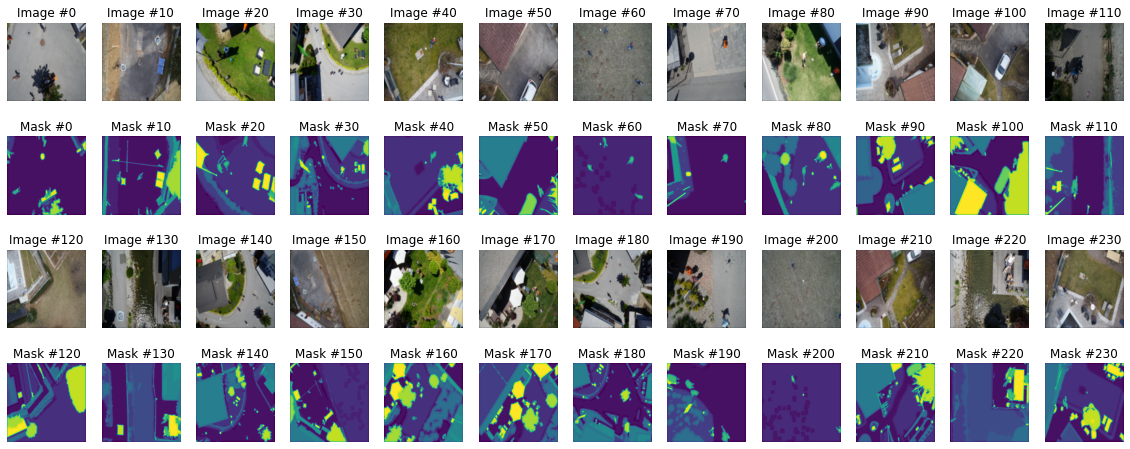

In [10]:
# Illustrate the train images and masks
plt.figure(figsize=(20,8))
x, y = 12,2
for i in range(y):  
    for j in range(x):
        
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

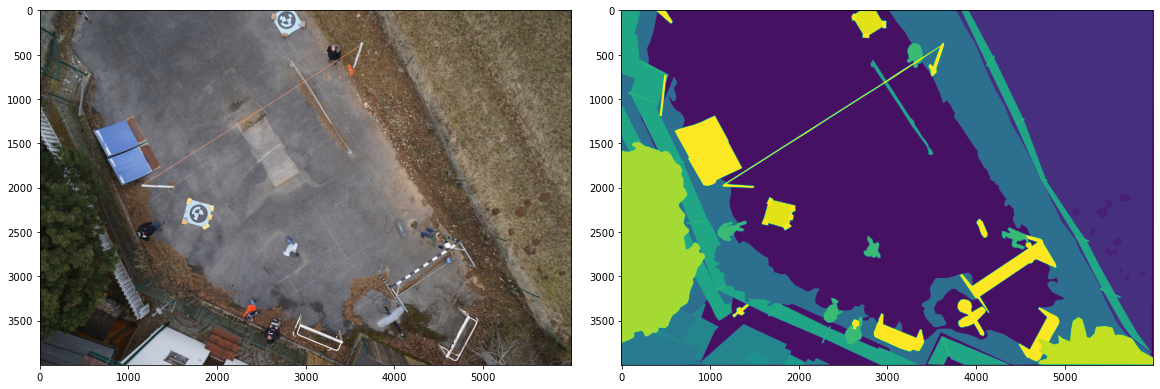

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

original_image = "D:/Utec/DL/semantic_drone_dataset/Train/original_images/001.jpg"
label_image_semantic = "D:/Utec/DL/semantic_drone_dataset/Train/label_images_semantic/001.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

In [12]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [13]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(20, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [14]:
# Initialize our callbacks
model_path = "./nuclei_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model 
results = model.fit(X_train, Y_train_onehot, validation_split=0.1,
                    batch_size=16, epochs=100, 
                    callbacks=[earlystop, checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 288 samples, validate on 32 samples
Epoch 1/100
288/288 [==============================] - 43s 149ms/step - loss: 2.6071 - dice_coef: 0.0832 - val_loss: 2.4350 - val_dice_coef: 0.1016

Epoch 00001: val_loss improved from inf to 2.43502, saving model to ./nuclei_finder_unet_1.h5
Epoch 2/100
288/288 [==============================] - 33s 115ms/step - loss: 2.2393 - dice_coef: 0.1745 - val_loss: 2.2557 - val_dice_coef: 0.1670

Epoch 00002: val_loss improved from 2.43502 to 2.25571, saving model to ./nuclei_finder_unet_1.h5
Epoch 3/100
288/288 [==============================] - 35s 121ms/step - loss: 2.1061 - dice_coef: 0.1953 - val_loss: 2.1320 - val_dice_coef: 0.1827

Epoch 00003: val_loss improved from 2.25571 to 2.13197, saving model to ./nuclei_finder_unet_1.h5
Epoch 4/100
288/288 [==============================] - 33s 115ms/step - loss: 2.0208 - dice_coef: 0.2074 - val_loss: 2.0562

288/288 [==============================] - 32s 112ms/step - loss: 1.3858 - dice_coef: 0.4215 - val_loss: 1.4665 - val_dice_coef: 0.4554

Epoch 00034: val_loss did not improve from 1.42868
Epoch 35/100
288/288 [==============================] - 32s 111ms/step - loss: 1.3486 - dice_coef: 0.4395 - val_loss: 1.4024 - val_dice_coef: 0.4570

Epoch 00035: val_loss improved from 1.42868 to 1.40241, saving model to ./nuclei_finder_unet_1.h5
Epoch 36/100
288/288 [==============================] - 33s 113ms/step - loss: 1.3398 - dice_coef: 0.4518 - val_loss: 1.4392 - val_dice_coef: 0.4668

Epoch 00036: val_loss did not improve from 1.40241
Epoch 37/100
288/288 [==============================] - 32s 112ms/step - loss: 1.3172 - dice_coef: 0.4543 - val_loss: 1.4597 - val_dice_coef: 0.4819

Epoch 00037: val_loss did not improve from 1.40241
Epoch 38/100
288/288 [==============================] - 32s 110ms/step - loss: 1.3304 - dice_coef: 0.4494 - val_loss: 1.4684 - val_dice_coef: 0.4769

Epoch 00038:

In [17]:
# Predict on training and validation data
model = load_model('./nuclei_finder_unet_1.h5', 
                   custom_objects={'dice_coef': dice_coef})

# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#preds_test = model.predict(X_test, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


32/32 [==============================] - 1s 37ms/step


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ploting our predicted masks
ix = random.randint(0, 287)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train[ix]))
plt.title("Predictions")
plt.show()

NameError: name 'preds_train' is not defined

In [ ]:
# Ploting our predicted masks
ix = random.randint(287, 321)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val[ix]))
plt.title("Predictions")
plt.show()

In [ ]:
from skimage.morphology import label

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)